##### Phase Objective: This notebook focuses on applying the CLTV predictions from our previous analysis. We will segment customers into actionable groups and propose tailored business strategies for each segment, showcasing how my data science work can directly drive business value.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\DELL\AppData\Local\Temp\ipykernel_8940\2083417712.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
print("Loading necessary data...")
try:
    # Load the feature-engineered data (RFM, Tenure, etc.)
    df_features = pd.read_csv('../data/processed/customer_features_rfm.csv')
    # Load the CLTV predictions from the probabilistic model
    df_predictions = pd.read_csv('../data/processed/cltv_predictions_probabilistic.csv')

    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure previous notebooks were run and saved.")
    exit()

Loading necessary data...
Data loaded successfully.


In [9]:
df_features.head()

,CustomerID,Recency,Frequency,Monetary,Tenure,Frequency_model,Recency_Model,AOV,AvgPurchaseGap,ProductDiversity
0,12346,326,1,77183.60,326,0,0,77183.60,0.00,1
1,12347,2,7,4310.00,367,6,365,615.71,2.00,103
2,12348,75,4,1797.24,358,3,282,449.31,9.40,22
3,12349,19,1,1757.55,19,0,0,1757.55,0.00,73
4,12350,310,1,334.40,310,0,0,334.40,0.00,17


In [10]:
df_predictions.head()

,CustomerID,frequency,recency,T,monetary,predicted_cltv
0,12346,0,0,326,77183.60,15144.81
1,12347,6,365,367,4310.00,186703.91
2,12348,3,282,358,1797.24,47943.39
3,12349,0,0,19,1757.55,77680.17
4,12350,0,0,310,334.40,15800.04


In [4]:
# Merge the features and predictions into a single DataFrame for analysis
# We will use the CustomerID to join the two dataframes
customer_df = pd.merge(df_features, df_predictions[['CustomerID', 'predicted_cltv']], on='CustomerID', how='inner')

print(f"\nFinal combined DataFrame shape: {customer_df.shape}")


Final combined DataFrame shape: (4338, 11)


In [5]:
print("Sample of the combined DataFrame:")
print(customer_df.head())

Sample of the combined DataFrame:
   CustomerID  Recency  Frequency  Monetary  Tenure  Frequency_model  Recency_Model      AOV  AvgPurchaseGap  ProductDiversity  predicted_cltv
0       12346      326          1  77183.60     326                0              0 77183.60            0.00                 1        15144.81
1       12347        2          7   4310.00     367                6            365   615.71            2.00               103       186703.91
2       12348       75          4   1797.24     358                3            282   449.31            9.40                22        47943.39
3       12349       19          1   1757.55      19                0              0  1757.55            0.00                73        77680.17
4       12350      310          1    334.40     310                0              0   334.40            0.00                17        15800.04


##### Customer segmentation based on predicted cltv

##### We will segment customers into tiers based on their predicted CLTV.
##### A common approach is using quantiles (e.g., top 20%, middle 60%, bottom 20%).
##### We will create 3 tiers: High-Value, Medium-Value, and Low-Value

In [6]:
# Remove any customers with 0 CLTV to focus on those with predicted future spend
customer_df = customer_df[customer_df['predicted_cltv'] > 0]


In [8]:
# Remove any customers with 0 CLTV to focus on those with predicted future spend
customer_df.head()


,CustomerID,Recency,Frequency,Monetary,Tenure,Frequency_model,Recency_Model,AOV,AvgPurchaseGap,ProductDiversity,predicted_cltv
0,12346,326,1,77183.60,326,0,0,77183.60,0.00,1,15144.81
1,12347,2,7,4310.00,367,6,365,615.71,2.00,103,186703.91
2,12348,75,4,1797.24,358,3,282,449.31,9.40,22,47943.39
3,12349,19,1,1757.55,19,0,0,1757.55,0.00,73,77680.17
4,12350,310,1,334.40,310,0,0,334.40,0.00,17,15800.04


##### Calculate the quantiles for our tiers

In [11]:

quantiles = customer_df['predicted_cltv'].quantile([0.2, 0.5, 0.8]).to_dict()
print("\nCLTV Quantile Tiers:")
print(quantiles)


CLTV Quantile Tiers:
{0.2: 19198.845521963252, 0.5: 43334.83972585184, 0.8: 98269.86207309132}


##### Function to assign a segment based on predicted CLTV

In [12]:

def cltv_segment(cltv):
    if cltv >= quantiles[0.8]:
        return 'High-Value'
    elif cltv >= quantiles[0.5]:
        return 'Medium-Value'
    elif cltv >= quantiles[0.2]:
        return 'Low-Value'
    else:
        return 'At-Risk/Churn'

####  Apply the segmentation function to the DataFrame

In [13]:

customer_df['Segment'] = customer_df['predicted_cltv'].apply(cltv_segment)


In [14]:
print("\nCustomer counts per segment:")
print(customer_df['Segment'].value_counts())


Customer counts per segment:
Segment
Medium-Value     1304
Low-Value        1298
At-Risk/Churn     868
High-Value        868
Name: count, dtype: int64


####  Now, let's analyze the characteristics of each segment to understand what makes a customer valuable or not. We'll look at the mean of our key features.

In [15]:

segment_summary = customer_df.groupby('Segment').agg(
    # RFM metrics
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean'),
    Avg_Tenure=('Tenure', 'mean'),
    Avg_AOV=('AOV', 'mean'),
    Avg_PurchaseGap=('AvgPurchaseGap', 'mean'),
    Avg_ProductDiversity=('ProductDiversity', 'mean'),
    # Predictions
    Avg_Predicted_CLTV=('predicted_cltv', 'mean')
).reset_index()

In [16]:
# Sort by Avg_Predicted_CLTV to show the hierarchy
segment_summary.sort_values(by='Avg_Predicted_CLTV', ascending=False, inplace=True)

print("\nSummary of key customer characteristics by segment:")
print(segment_summary)



Summary of key customer characteristics by segment:
         Segment  Avg_Recency  Avg_Frequency  Avg_Monetary  Avg_Tenure  Avg_AOV  Avg_PurchaseGap  Avg_ProductDiversity  Avg_Predicted_CLTV
1     High-Value        20.90          12.03       7327.64      280.18   684.66             2.18                145.30          1501714.06
3   Medium-Value        39.31           2.78        966.98      139.81   375.16             1.76                 53.22            63903.75
2      Low-Value       104.28           2.22        660.40      211.26   336.35             3.65                 37.90            29087.36
0  At-Risk/Churn       226.58           1.71        470.83      309.89   341.21             5.80                 25.43            15476.88


#### Visualizations of findings

C:\Users\DELL\AppData\Local\Temp\ipykernel_8940\4116103442.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segment', y='Avg_Predicted_CLTV', data=segment_summary, palette='viridis')


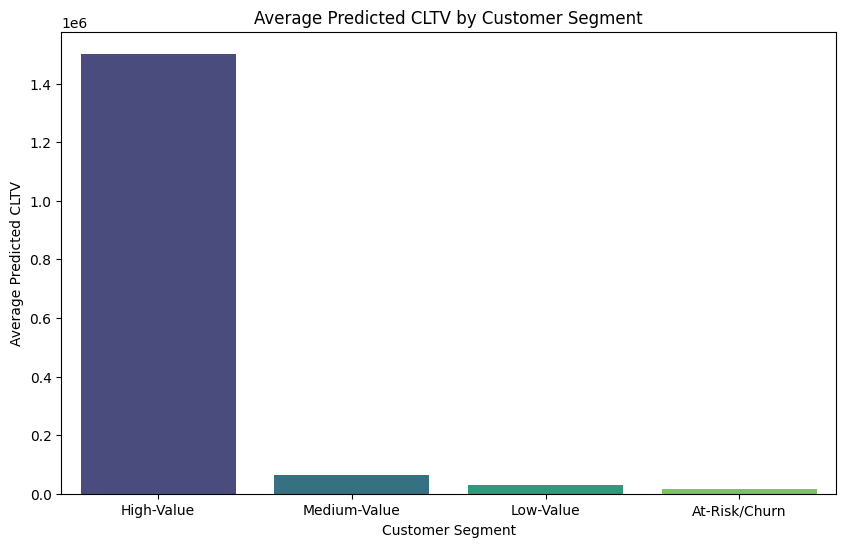

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Segment', y='Avg_Predicted_CLTV', data=segment_summary, palette='viridis')
plt.title('Average Predicted CLTV by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Predicted CLTV')
plt.show()

#### Key Insights

#### We divided our customers into four segments based on their purchase behavior and predicted future value (CLTV). These are my understanding:

#### 1. High-Value Customers
- Buy frequently (12+ times on average)
- Spend a lot (₹7,327 average total spend)
- Recently active (last purchase ~21 days ago)
- Very high predicted CLTV (₹15+ lakhs)
These are our **most valuable and loyal customers**.  
We should focus on **retaining them** with loyalty programs, early offers, and personalized services.

---

#### 2. Medium-Value Customers
- Buy occasionally (~3 times)
- Spend a moderate amount (₹966)
- Less recent activity (~39 days ago)
- Good predicted CLTV (~₹63,000)
These are **potentially loyal customers**.  
We can **nurture them** with special deals, reminders, and upselling strategies.

---

#### 3. Low-Value Customers
- Few purchases (~2 times)
- Lower spend (₹660)
- Less frequent (gap between orders is ~3.6 days)
- Low predicted CLTV (~₹29,000)
These customers show **limited engagement**.  
Try **re-engagement campaigns**, product recommendations, or discounts to boost interest.

---

#### 4. At-Risk / Churn Customers
- Haven’t purchased in a long time (~227 days ago)
- Low purchase frequency (~1.7)
- Lowest spend (₹470)
- Lowest predicted CLTV (~₹15,000)
These customers are **likely to churn** or have already left.  
Consider **win-back campaigns**, surveys, or exit offers to bring them back.

---

#### Conclusion:
This segmentation helps us understand which customers:
- Are most profitable (High-Value)
- Can be retained or upgraded (Medium & Low-Value)
- Need attention before we lose them (At-Risk)


